In [2]:
# Imports
import torch
from torch.distributions import Normal
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image

In [3]:
images, ground_truth = torch.load('MNIST/processed/training.pt')

In [4]:
print(images.shape)
print(ground_truth.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [5]:
print(torch.min(images[0]))
print(torch.max(images[0]))

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)


In [6]:
images[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

tensor(3)


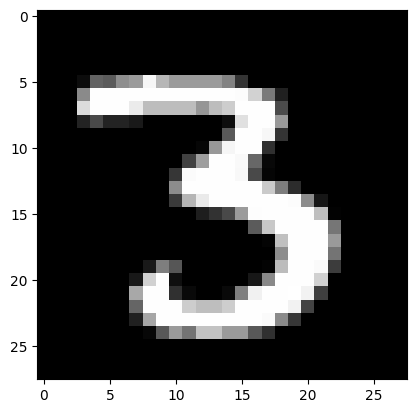

In [7]:
image_index = 12
print(ground_truth[image_index])
plt.imshow(images[image_index], cmap='gray')

In [8]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, path):
        self.images, self.ground_truth = torch.load(path)
        
    def __getitem__(self, idx):
        """
        Returns image with index idx
        """
        x = self.images[idx].float()
        x = torch.Tensor(x)
        x = torch.flatten(x) 
        return x
    
    def __len__(self):
        return len(self.ground_truth)

In [9]:
# make datasets
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [10]:
train_dataset[15].shape
# train_dataset[15]

torch.Size([784])

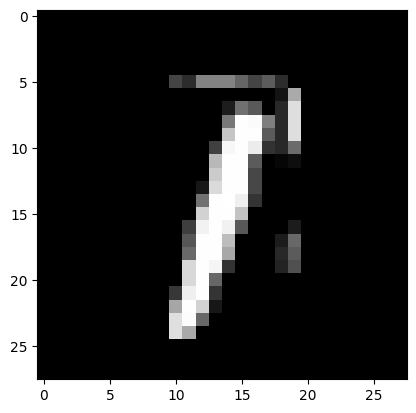

In [11]:
plt.imshow(train_dataset[67].numpy().reshape((28,28)), cmap='gray')


### AutoEncoder
$MSE =  \frac{1}{N} \sum_{i=1}^{n}(X_i - \hat{X}_i)^2$

Architecture:

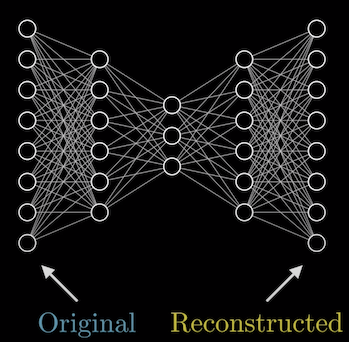

In [12]:
import torch.nn as nn 

class AutoEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim=128):
        super().__init__()
    
        # two fully connected layers for encoder (input_shape -> latent_dim)
        self.encoder_l1 = nn.Linear(in_features=input_shape, out_features=latent_dim)
        self.encoder_l2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        
        # two fully connected layers for decoder (128 -> input_shape)
        self.decoder_l1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.decoder_l2 = nn.Linear(in_features=latent_dim, out_features=input_shape)
        
    def forward(self, x):
        latent = self.run_encoder(x)
        x_hat = self.run_decoder(latent)
        return x_hat
        
    def run_encoder(self,x):
        output = F.relu(self.encoder_l1(x))
        latent = F.relu(self.encoder_l2(output)) 
        return latent # latent representation
    
    def run_decoder(self,latent):
        output = F.relu(self.decoder_l1(latent))
        x_hat = F.relu(self.decoder_l2(output))
        return x_hat # reconstructed images
    


### Model Training

In [13]:
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

# get shape of input data
image_shape = train_dataset[0].shape[0]
print(image_shape)

# Initialize AutoEncoder
model = AutoEncoder(input_shape=image_shape)
model.cuda()
model.train()

784


AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

In [14]:
batch_test = torch.randn(128,784).cuda() # batch_size = 128
output = model(batch_test)

print(output)
print(output.shape)


tensor([[0.0261, 0.0000, 0.0601,  ..., 0.0000, 0.0061, 0.0572],
        [0.0081, 0.0000, 0.0489,  ..., 0.0000, 0.0531, 0.0121],
        [0.0479, 0.0000, 0.0874,  ..., 0.0000, 0.0431, 0.0880],
        ...,
        [0.0068, 0.0240, 0.0783,  ..., 0.0000, 0.0000, 0.0202],
        [0.0461, 0.0126, 0.1104,  ..., 0.0000, 0.0429, 0.0352],
        [0.0000, 0.0000, 0.0822,  ..., 0.0000, 0.0670, 0.0396]],
       device='cuda:0', grad_fn=<ReluBackward0>)
torch.Size([128, 784])


In [15]:
import torch.optim as optim
# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True)

# Loss
mse = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100

for epoch in range(n_epochs):
    loss = 0
    
    for batch_features in train_loader:
        batch_features = batch_features.cuda()
        
        optimizer.zero_grad()
        
        # compute reconstruction
        outputs = model(batch_features)
        
        # Debugging print statements
        # if outputs is None:
        #     print("model output is None")
        #     continue
        
        # compute training reconstruction loss
        train_loss = mse(outputs, batch_features)
    
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add mini-batch training loss to epoch loss
        loss += train_loss.item()
        
    # compute epoch training loss
    loss = loss / len(train_loader)
    
    if epoch %5 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))
    
    
print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))


epoch : 1/100, loss = 2069.177739
epoch : 6/100, loss = 895.603365
epoch : 11/100, loss = 824.541596
epoch : 16/100, loss = 792.720422
epoch : 21/100, loss = 772.689361
epoch : 26/100, loss = 758.560588
epoch : 31/100, loss = 748.198561
epoch : 36/100, loss = 741.462315
epoch : 41/100, loss = 736.747827
epoch : 46/100, loss = 732.085133
epoch : 51/100, loss = 725.523486
epoch : 56/100, loss = 722.942245
epoch : 61/100, loss = 719.738878
epoch : 66/100, loss = 717.790981
epoch : 71/100, loss = 716.152816
epoch : 76/100, loss = 715.039831
epoch : 81/100, loss = 713.876504
epoch : 86/100, loss = 712.571725
epoch : 91/100, loss = 712.082101
epoch : 96/100, loss = 710.896284
epoch : 100/100, loss = 710.324580


### Model Evaluating

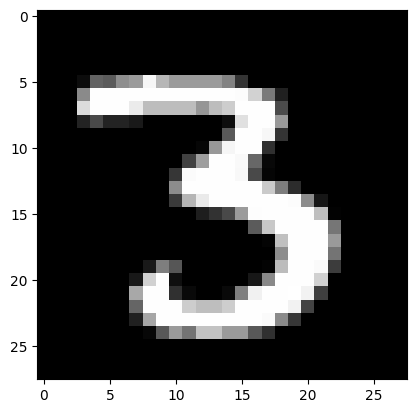

In [16]:
model.eval()
image_idx = 50
image = train_dataset[image_index]
plt.imshow(image.reshape((28,28)), cmap='gray')

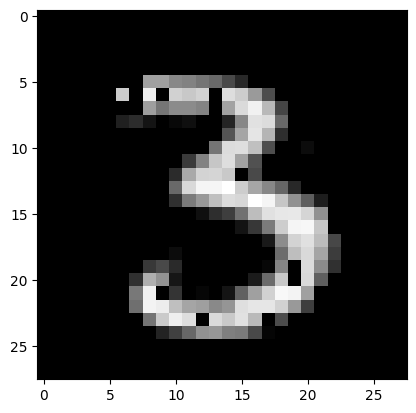

In [17]:
image_gpu = image.cuda()
x_hat = model(image_gpu)
x_hat_cpu = x_hat.detach().cpu().reshape((28,28))
x_hat_cpu = np.around(x_hat_cpu)

plt.imshow(x_hat_cpu, cmap='gray') # reconstructed image

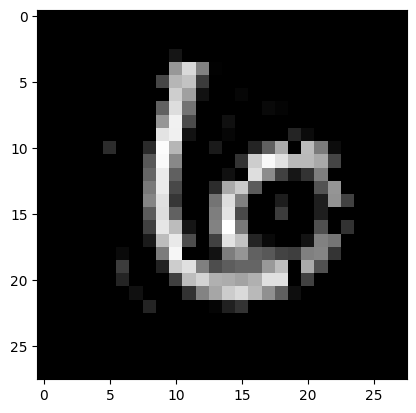

In [18]:
# Visualizing test images
image_idx = 100

image = test_dataset[image_idx].cuda()
x_hat = model(image)
x_hat = x_hat.detach().cpu().numpy().reshape((28,28))
x_hat = np.around(x_hat)

plt.imshow(x_hat, cmap='gray')

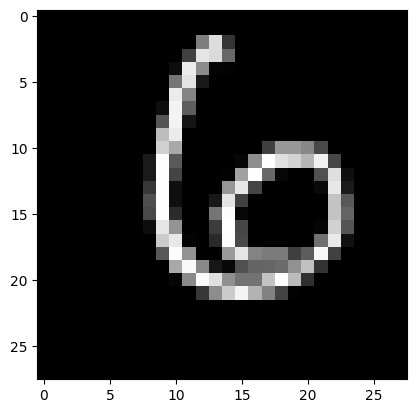

In [19]:
plt.imshow(image.cpu().reshape((28,28)), cmap='gray') # ground truth test image

### Getting latent representation

In [20]:
@torch.no_grad() # wrapping function
def get_latent_representation(model, dataloader):
    latent_representation = []
    for batch in dataloader:
        batch = batch.cuda()
        # Run encoder only
        latent = model.run_encoder(batch)
        latent = latent.cpu().numpy() # due to @torch.no_grad(), detach() not needed
        latent_representation.append(latent)
    latent_representation = np.concatenate(latent_representation)
    return latent_representation

latent = get_latent_representation(model, train_loader)
latent.shape

(60000, 128)

### Extending to VAE

General Architecture:

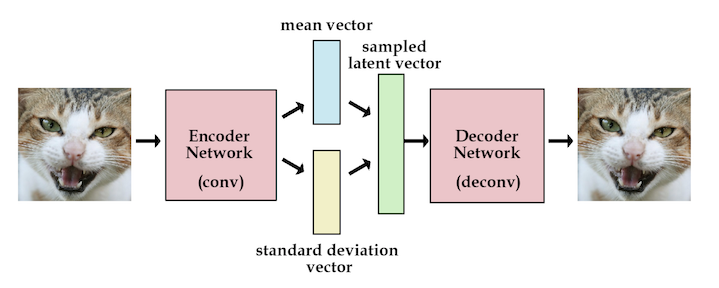

#### VAE Loss function

Evidence Lower Bound :

$ELBO = E_{q(z|x)}logp(x|z) - KL(q(z|x)||p(z))$

$ELBO = Reconstruction Loss - KL Divergence$


KL divergence defined as:

$KL(q(x)||p(x)) = \int{p(x)log(\frac{p(x)}{q(x)})dx}$

In [21]:
kernel_size = 4
init_channels= 8 # initial number of filters
image_channels = 1 # grayscale (MNIST images)
latent_dim = 16 # latent dimension for sampling


In [23]:
class ConvVAE(nn.Module):
    def __init__(self,
                 image_channels=1,
                 kernel_size=4,
                 latent_dim=16,
                 init_channels=8):
        super(ConvVAE, self).__init__()
        
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels,
            out_channels=init_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels,
            out_channels=init_channels*2,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2,
            out_channels=init_channels*4,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4,
            out_channels=init_channels*64,
            kernel_size=kernel_size,
            stride=2,
            padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim) # log_var : non-negative
        self.fc2 = nn.Linear(latent_dim, 64)
        
        # decoder
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
    
    def reparameterize(self, mu, log_var):
        # Reparamaterization trick: instead of x ~ N(mu, std),
        # do: x = mu + std * N(0,1)
        # then compute gradients w.r.t mu and std possible
        std = torch.exp(0.5*log_var)
        eps = torch.rand_like(std) # initial sample as same size of std
        sample = mu + (eps*std) # actual sampling
        return sample
    
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))        
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, output_size=1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get 'mu' and 'log_var'
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        
        # get latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1) # latent representation
        
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var
        

In [ ]:
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"{epoch}.jpg")